In [1]:
# Importing the required libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from model import SimpleNN
from util import training_loop, show_images

## Loading the data

In [2]:
# Load MNIST dataset (TensorFlow/Keras)
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Transform dataset: normalize and convert to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Note: Running the above cell will create a new folder called 'data' in your working directory.

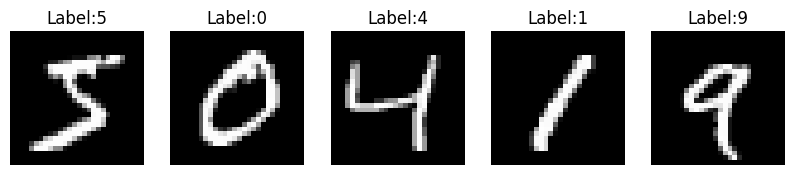

In [3]:
show_images(train_dataset)

In [ ]:
# Calling the model from model.py
